# Using custom fixed points

Sometimes, cleverly choosing the points to do the computation can result in more efficient process.
For example, around the region where the canyon curves, we would want to have more points to capture the shape of the canyon.
On the other hand, in some region the canyon might look like a line (the canyon doesn't curve significantly).
In this case, we don't need as much point to capture the shape of the canyon.
This can possibly speed up the computation, because we can require fewer number of points in our computation.

To show this, we will compare the results of profile likelihood computation using the sum of exponentials model.
We will run the computation using linearly spaced points (using the internal algorithm to generate the points) and some custom points.
We will compare the time to run for each computation.
Additionally, we will also compare the results qualitatively by plotting the profile likelihood paths on the cost contour and comparing the profile likelihood.

## Define the model, profile likelihood object, and cost contour data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from profile_likelihood import profile_likelihood
import model_trigonometric as model
import manifold

%matplotlib inline

## Define the model

The model is defined as the sum of trigonometric functions, in the form of
$$ f\left(t; \vec{\theta}\right) = \sin(\theta_0 t) + \cos(\theta_1 t), $$
where we sample at 3 time points $t = [1.0, 1.2, 2.0]^T$.
The default parameters are chosen to be $\vec{\theta} = [1.0, 2.5]^T$.
The data is set to be the predictions of the model at the default parameters and the standard deviation is chosen to be 30% of the data.
The implementation of this model is given in `model_trigonometric.py`.

In [2]:
# Define the variables from model
best_fit = model.best_fit
param_names = model.param_names
nparams = model.nparams
npred = model.npred

# Define the likelihood object
likelihood = profile_likelihood(model.residuals, nparams, npred)
bounds = [-5, 5]

In [3]:
# Get cost contour data
Theta0, Theta1, Cost = manifold.cost_contour_data(
    model.cost,
    xlist=np.linspace(-5, 5, 100),
    ylist=np.linspace(-5, 5, 100),
)

## Run computation using linearly spaced points

In [4]:
%%time
# Run the computation
results_linspace = likelihood.compute(best_fit, bounds=bounds, dt=0.1, processes=2)

Task for parameter1 is done by Process-3
Task for parameter0 is done by Process-2
CPU times: user 21.4 ms, sys: 24.5 ms, total: 45.9 ms
Wall time: 396 ms


In [5]:
ldata0_linspace = likelihood.results["parameter0"]
ldata1_linspace = likelihood.results["parameter1"]

## Run computation using custom points

In [6]:
# Define function to map linearly spaced points to the desired points
def f(x, x0):
    # return 2 / np.pi * np.arctan(x - x0) * abs(x - x0) + x0
    return (x - x0) ** 3 / 200


# Define the points that will be used
ll = np.arange(-10, 10 + 0.3 / 2, 0.3)
points = [[f(x + x0, x0) for x in ll] for x0 in [-np.pi / 2, 0]]

In [7]:
%%time
# Run the computation
results_custom = likelihood.compute(best_fit, points=points, processes=2)

Task for parameter0 is done by Process-5
Task for parameter1 is done by Process-6
CPU times: user 13.2 ms, sys: 21.6 ms, total: 34.8 ms
Wall time: 270 ms


In [8]:
ldata0_custom = likelihood.results["parameter0"]
ldata1_custom = likelihood.results["parameter1"]

The computation using the custom points is faster, but it is because we use fewer number of points here.
Next, we will qualitatively compare the results.

## Comparison of the profile likelihood paths

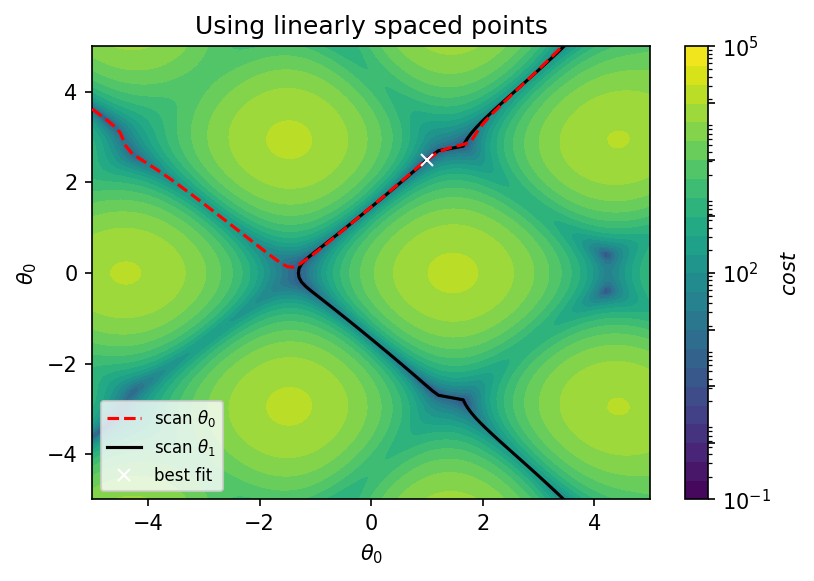

In [9]:
# Plot the profile likelihood paths using linearly spaced points
ax, clb = manifold.plot_cost_contour(Theta0, Theta1, Cost, levels=25, scale="log")
plt.title("Using linearly spaced points")
ax.plot(
    ldata0_linspace["parameters"][:, 0],
    ldata0_linspace["parameters"][:, 1],
    "r--",
    label=f"scan {param_names[0]}",
    zorder=10,
)
ax.plot(
    ldata1_linspace["parameters"][:, 0],
    ldata1_linspace["parameters"][:, 1],
    "k-",
    label=f"scan {param_names[1]}",
)
ax.plot(best_fit[0], best_fit[1], "wx", label="best fit", zorder=20)
ax.set_xlim((-5, 5))
ax.set_ylim((-5, 5))
ax.set_xlabel(param_names[0])
ax.set_ylabel(param_names[0])
clb.set_label(r"$cost$")
plt.legend(fontsize=8)
plt.show()
plt.close()

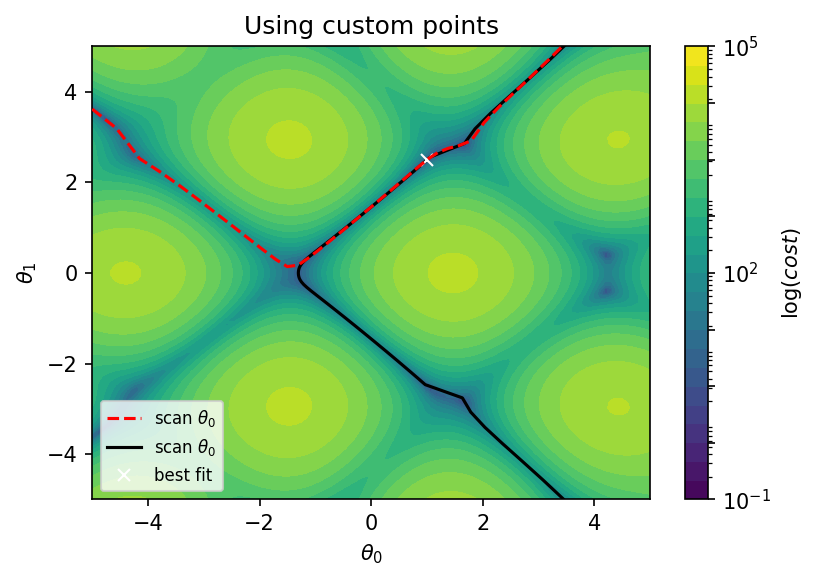

In [10]:
# Plot the profile likelihood paths using linearly spaced points
ax, clb = manifold.plot_cost_contour(Theta0, Theta1, Cost, levels=25, scale="log")
plt.title("Using custom points")
ax.plot(
    ldata0_custom["parameters"][:, 0],
    ldata0_custom["parameters"][:, 1],
    "r--",
    label=f"scan {param_names[0]}",
    zorder=10,
)
ax.plot(
    ldata1_custom["parameters"][:, 0],
    ldata1_custom["parameters"][:, 1],
    "k-",
    label=f"scan {param_names[0]}",
)
ax.plot(best_fit[0], best_fit[1], "wx", label="best fit")
ax.set_xlim((-5, 5))
ax.set_ylim((-5, 5))
ax.set_xlabel(param_names[0])
ax.set_ylabel(param_names[1])
clb.set_label(r"$\log(cost)$")
plt.legend(fontsize=8)
plt.show()
plt.close()

In short, the profile likelihood paths from the 2 computations are comparable.

## Comparison of the cost values

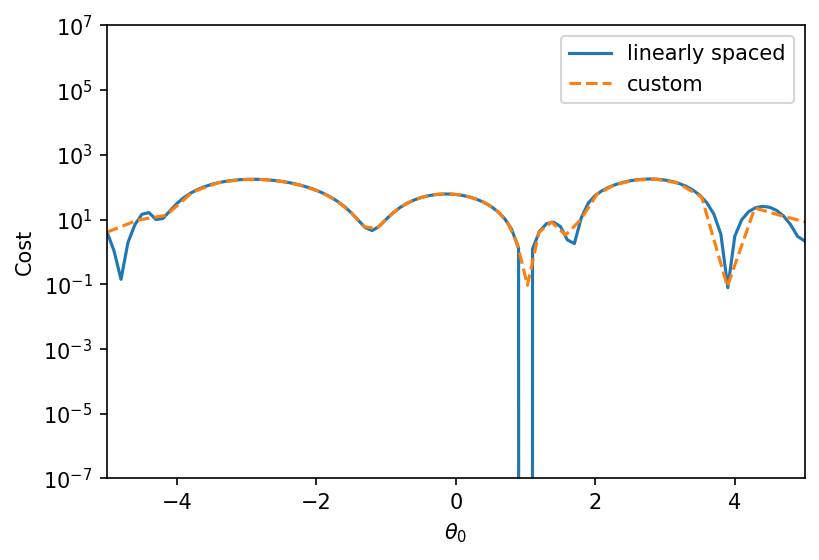

In [11]:
# Plot the cost along theta_0 direction
plt.figure(dpi=150, facecolor="w")
plt.plot(
    ldata0_linspace["parameters"][:, 0],
    ldata0_linspace["cost"],
    label="linearly spaced",
)
plt.plot(ldata0_custom["parameters"][:, 0], ldata0_custom["cost"], "--", label="custom")
plt.xlim(-5, 5)
plt.yscale("log")
plt.ylim(1e-7, 1e7)
plt.xlabel(param_names[0])
plt.ylabel("Cost")
plt.legend()
plt.show()
plt.close()

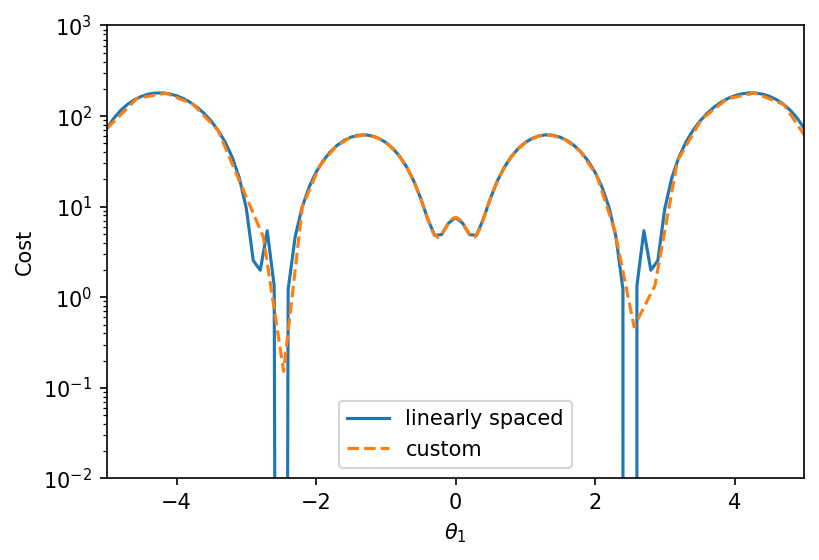

In [12]:
# Plot the cost along theta_0 direction
plt.figure(dpi=150, facecolor="w")
plt.plot(
    ldata1_linspace["parameters"][:, 1],
    ldata1_linspace["cost"],
    label="linearly spaced",
)
plt.plot(ldata1_custom["parameters"][:, 1], ldata1_custom["cost"], "--", label="custom")
plt.xlim(-5, 5)
plt.yscale("log")
plt.ylim(1e-2, 1e3)
plt.xlabel(param_names[1])
plt.ylabel("Cost")
plt.legend()
plt.show()
plt.close()

On these plots, the two results are comparable.